# Sort spikes and make bout/motif rasters
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
import pickle

In [3]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import syncutil as su
from ceciestunepipe.util import sglxsync as syn

from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [4]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-11-09 15:19:53,167 root         INFO     all modules loaded


In [5]:
si.__version__

'0.12.0'

In [6]:
se.__version__

'0.9.3'

### Session parameters and raw files

In [7]:
reload(et)
bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [8]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 'sort_0'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [9]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx'

In [10]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-11-09 15:20:02,828 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/sort_0', 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/sort_0'}, 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/sort_0/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/experiment/s_b1253_21/

['0712_g0', '1255_g0', '1740_g0', '2118_g0']

In [11]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch
sess_par['sort'] = 'sort_0'

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [12]:
#exp_struct['folders']['raw'] = 'tuvieja'
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0712_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/0712_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-06-14/0712_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0',
  'tmp': '/experiment/tmp/tmp/0712_g0',
  'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-06-14/0712_g0',
  'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/0712_g0/sort_0',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0'},
 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/0712_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.

In [13]:
sglu

<module 'ceciestunepipe.util.sglxutil' from '/home/finch/repos/ceciestunepipe/ceciestunepipe/util/sglxutil.py'>

In [14]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0'}

In [15]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/0712_g0/0712_g0_imec0/0712_g0_t0.imec0.ap.meta']}

In [16]:
files_pd = pd.DataFrame(sgl_files)

In [17]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...


### load epoch files

In [18]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


### do the sync
- get the sync events from the recordings 
- write the npy sync event files

In [19]:
from ceciestunepipe.util import sglxsync as syn

##### get the syn patterns for all of the signals

In [20]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: syn.get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2021-11-09 15:20:09,566 ceciestunepipe.util.sglxsync INFO     getting syn patterns for nidq
2021-11-09 15:20:09,589 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/nidq_sync_dict.pkl
2021-11-09 15:21:06,908 ceciestunepipe.util.sglxsync INFO     getting syn patterns for lf_0
2021-11-09 15:21:06,926 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/lf_0_sync_dict.pkl
2021-11-09 15:21:14,162 ceciestunepipe.util.sglxsync INFO     getting syn patterns for ap_0
2021-11-09 15:21:14,174 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/ap_0_sync_dict.pkl
2021-11-09 15:21:14,331 ceciestunepipe.util.sglxsync INFO     getting syn patterns for wav
2021-11-09 15:21:14,343 ceciestunepipe.util.sglxsync INFO     loading syn_dict from /mnt/sphere/speech_bci/deri

#### do the synchronization usin the syn dict

### get all of the streams syncched to a reference_stream

In [21]:
ref_stream = 'ap_0'
syn.sync_all(all_syn_dict, 'ap_0', force=False)

2021-11-09 15:21:14,486 ceciestunepipe.util.sglxsync INFO     syncing all times to ap_0
2021-11-09 15:21:14,487 ceciestunepipe.util.sglxsync INFO      synch nidq...
2021-11-09 15:21:14,709 ceciestunepipe.util.sglxsync INFO      synch lf_0...
2021-11-09 15:21:14,848 ceciestunepipe.util.sglxsync INFO      synch wav...


In [22]:
all_syn_dict['wav']

{'s_f': 20000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_sync_evt.npy',
 'evt_arr': memmap([[     7031,     17031,     27030, ..., 411671456, 411681456,
          411691456],
         [        1,        -1,         1, ...,        -1,         1,
                 -1]]),
 't_0': memmap([0.00000000e+00, 5.00000000e-05, 1.00000000e-04, ...,
         2.05850232e+04, 2.05850232e+04, 2.05850232e+04]),
 't_p': memmap([2.65632550e-05, 7.65664408e-05, 1.26569627e-04, ...,
         2.05853020e+04, 2.05853021e+04, 2.05853021e+04])}

## Get the bouts
- read the curated bouts file (or a list) for the epoch
- get starts:ends in t_naive of the wav file
- get the corresponding tprimes to refer to the spikes

#### plot a sample bout

In [23]:
##### the bouts pandas file filtered for this session
bout_pd = et.get_epoch_bout_pd(sess_par, only_curated=True)
bout_dict = syn.bout_dict_from_pd(bout_pd, all_syn_dict)

2021-11-09 15:21:15,076 ceciestunepipe.file.bcistructure INFO     loading curated bouts for session 2021-06-14 from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/bouts_sglx/bout_curated.pickle
2021-11-09 15:22:14,480 ceciestunepipe.file.bcistructure INFO     Filtering bouts for epoch 0712_g0
2021-11-09 15:22:14,821 ceciestunepipe.file.bcistructure INFO     Filtering also only manually curated bouts


In [24]:
sess_par

{'bird': 's_b1253_21',
 'sess': '2021-06-14',
 'probe': 'probe_0',
 'sort': 'sort_0',
 'epoch': '0712_g0'}

### Save the synced mot_dict data

In [25]:
os.makedirs(exp_struct['folders']['sort'], exist_ok=True)

In [26]:
bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ap0.pkl')
with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

In [28]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0/bout_dict_ap0.pkl'

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [29]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()-1

In [ ]:
ap_extractor = run_recordings['ap_0']

###### view it raw

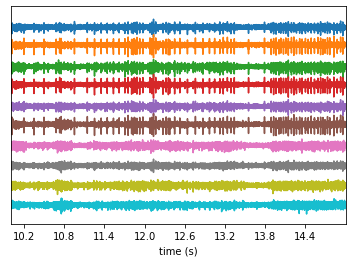

In [86]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[10,15])

In [40]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0610_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/0610_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/0610_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'tmp': '/experiment/tmp/tmp/0610_g0',
 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18/0610_g0',
 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/sort_0',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0'}

In [38]:
ss.__version__

'0.4.4'

In [39]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [40]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [42]:
ks_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0'

#### run the spike sort

In [45]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')

# sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, 
#                      sorting_method='kilosort3', 
#                      **ks_params)

2021-09-25 18:29:17,074 root         INFO     Grouping property: None
2021-09-25 18:29:17,075 root         INFO     sorting method: kilosort3
2021-09-25 18:29:17,077 root         INFO     Sorting tmp dir /experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/tmp_ks3
2021-09-25 18:29:17,077 root         INFO     Will set visible gpu devices 1
Writing to binary .dat file: 100%|##########| 1329/1329 [2:22:45<00:00,  6.44s/it] 


SpikeSortingError: Spike sorting failed: kilosort3 returned a non-zero exit code. You can inspect the runtime trace in the kilosort3.log of the output folder.'

#### load the sort

In [30]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle.dump.pkl')
sort_pickle_path

'/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/0712_g0/sort_0/sort_ks3.pickle.dump.pkl'

In [31]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [32]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [33]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters,cluster_id
0,104,91,91


In [43]:
## call the HVC/RA sites
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
ra_chans = np.arange(15, 140)
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
clu_pickle_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')

os.makedirs(exp_struct['folders']['sort'], exist_ok=True)
spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [45]:
### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
clu_pickle_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')

os.makedirs(exp_struct['folders']['sort'], exist_ok=True)
spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [44]:
exp_struct['folders']['sort']

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0'

In [36]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
3,3,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 15, 19, 14, 13, 16, 21, 12, 25, 18, 22, 2...",17,"[13, 14, 15, 16, 17, 19, 21]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",ra


In [40]:
/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/sort_0/clu_df.pkl'



SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-40-cc0b7f38c642>, line 1)

In [37]:
clu_df_ra = clu_df[clu_df['nucleus']=='ra']
np.unique(clu_df_ra['cluster_id']).size

186

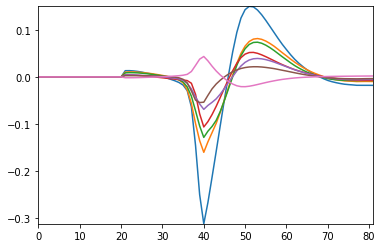

In [39]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### plot a raster

In [147]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.652952032644,
 's_f_ap_0': 30000.043852965577,
 'start_ms': array([ 6300478,  7102501,  7180616,  7245376,  7661606,  8031581,
         8128521,  8202321,  8442876,  9853004, 11014954, 12578659,
        14212972, 15410472, 15496242, 17104694, 18395779, 20073717,
        20107052, 21557542, 21939152, 23513780, 23676120, 23753090,
        23766770, 24457160, 24816190, 27239488, 27308728, 27405768,
        27495628, 27737218, 28437448, 29355223]),
 'len_ms': array([50765, 38435, 31900, 44620, 55725, 47565, 39805, 34070, 60000,
        45875, 45460, 41365, 39195, 58425, 52140, 46640, 21695, 17460,
        39010, 47655, 52790, 23410, 42345,  9165, 18225, 51855, 57915,
        34420, 42935, 35810, 40380, 51640, 63155, 19065]),
 'start_sample_naive': array([157511950, 177562525, 179515400, 181134400, 191540150, 200789525,
        203213025, 205058025, 211071900, 246325100, 275373850, 314466475,
        355324300, 385261800, 387406050, 427617350, 459894475, 50

### Visualize a bout together with the neural traces

In [49]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util import wavutil as wu

In [50]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [51]:
bout_dict

{'s_f': 20000,
 's_f_nidq': 19999.729158569764,
 's_f_ap_0': 30000.08851535173,
 'start_ms': array([   15800,    64885,   111190,   190095,   283895,   369800,
          412825,   465990,  1328125,  1376105,  1423335,  1477160,
         1512355,  1586860,  1628115,  1910165,  1970520,  2019450,
         2654135,  2767900,  3010380,  3138260,  3214210,  3274870,
         3331205,  3384190,  3447425,  3850055,  3919895,  3974050,
         4033260,  4138984,  4229784,  4324329,  4994229,  5110494,
         5263984,  5439614,  5560609,  6411079,  6718919,  6771749,
        16330959, 16392354, 17009938, 17237093, 17397973]),
 'len_ms': array([36545, 29620, 35175, 26205, 29050, 27995, 32645, 25925, 32535,
        32130, 33315, 23770, 26845, 24490, 22345, 39110, 34160, 37055,
        31140, 48320, 31605, 43125, 30175, 30100, 32505, 29350, 28735,
        48615, 31550, 31510, 29910, 40685, 39965, 38570, 42675, 44760,
        30875, 33265, 32100, 40710, 33780, 30400, 31370, 32610, 31345,
       

In [52]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [53]:
ap_sf = all_syn_dict['ap_0']['s_f']

### one example of bout onset

In [54]:
#hvc_chans = list(range(290, 324)) #HVC
ra_chans = list(range(15, 140)) #RA

#neur_chans = hvc_chans + ra_chans
neur_chans = ra_chans

mot_idx = 0

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 4 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-55-12a952a9720b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
<ipython-input-55-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


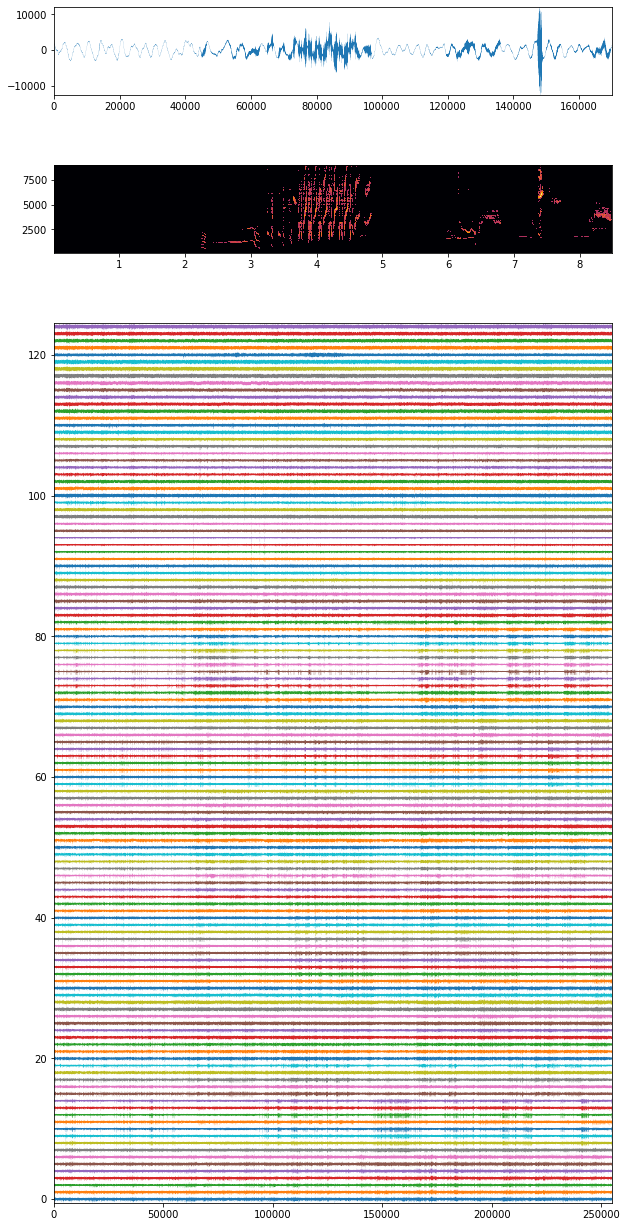

In [55]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

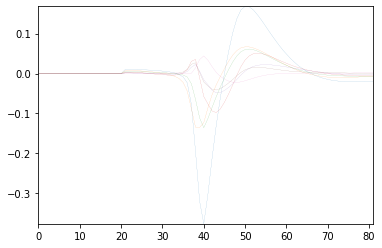

In [56]:
plt.plot(clu_df.loc[12, 'main_wav_7']);

#### check alignment of the syn signals

In [57]:
## have to do it, but it won't be like this
# n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
# ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

# n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
# nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [58]:
# mot_idx = 8
# sec_before = 0
# sec_after = 10

# for mot_idx in range(2):
#     start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
#     end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

#     start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
#     end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

#     fig, ax = plt.subplots(nrows=2)
#     ax[0].plot(ap_syn[start_ap: end_ap], '-*')
#     ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
#     ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [59]:
reload(ks)
reload(syn)

def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)


    # get the streams/spike array
    spk_arr = ks.get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])
#clu_list = np.unique(clu_df['cluster_id'])

t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
spk_arr, mic_arr = syn.collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream, all_syn_dict)


#rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:132: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [60]:
clu_list.size

186

<ipython-input-61-bd64432d1d6b>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


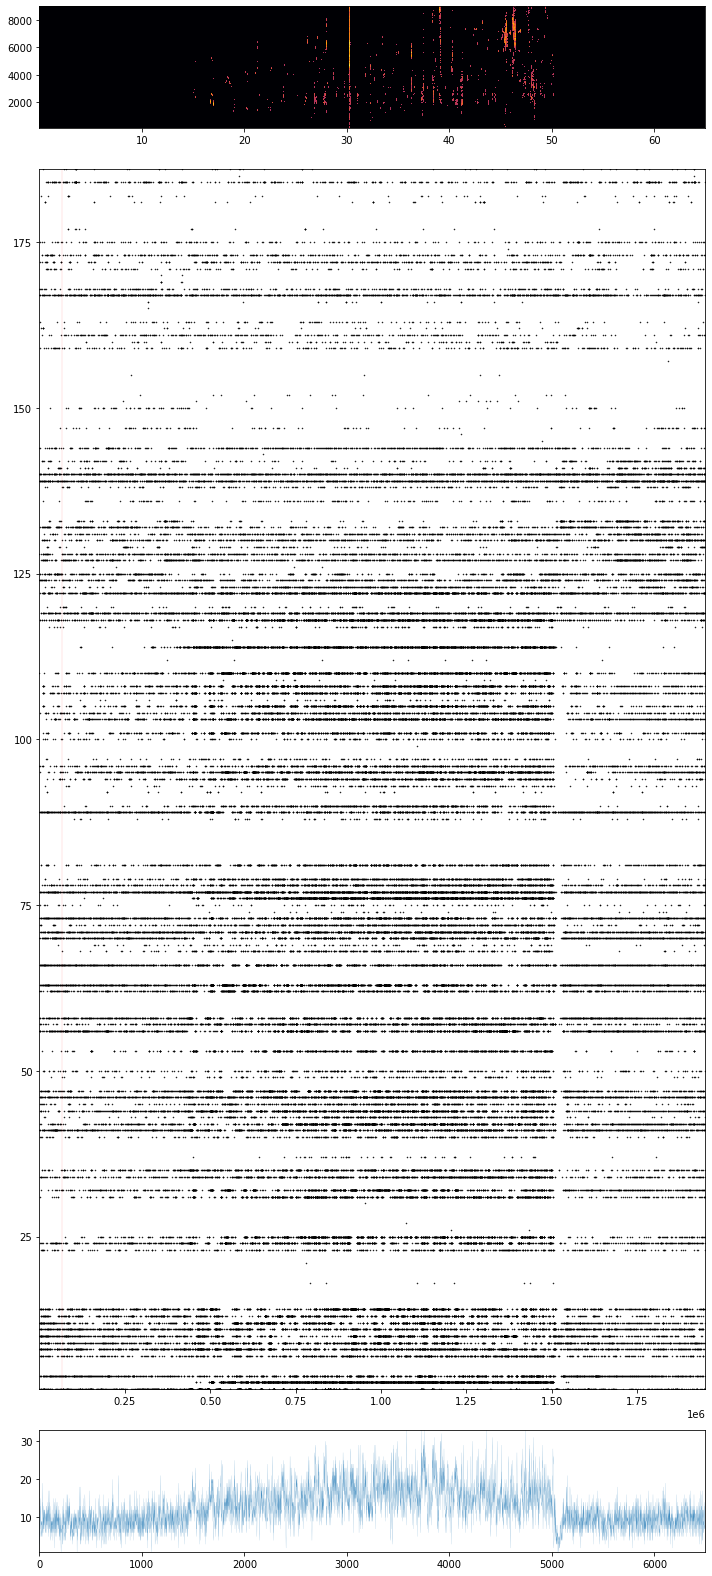

In [61]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

clu_list = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])
#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2

# get the streams/spike array
spk_arr, mic_arr = syn.collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream, all_syn_dict)


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [62]:
from ceciestunepipe.util import plotutil as pu

In [63]:
bin_size_sample

300

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


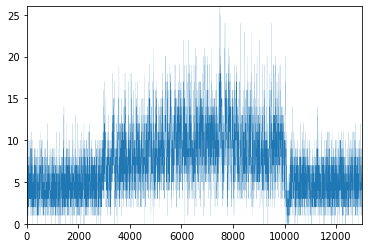

In [64]:
# plot a 'psth' of the summed activity of all units
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'] )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

plt.plot(psth);

In [ ]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster, motif and cluster metadata

In [ ]:
import pickle

In [124]:
exp_struct['folders']['sort']

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0'

In [125]:
clu_df_path = os.path.join(exp_struct['folders']['sort'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['sort'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)


In [ ]:
exp_struct['folders']['processed']

In [48]:
bin_spk_arr.shape

NameError: name 'bin_spk_arr' is not defined

### Collect all bouts for all clusters and make a dataframe

In [63]:
clu_list = np.unique(clu_df.loc[(clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])
clu_list.shape

(79,)

In [62]:
reload(syn)

<module 'ceciestunepipe.util.sglxsync' from '/home/finch/repos/ceciestunepipe/ceciestunepipe/util/sglxsync.py'>

In [67]:
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = -5
t_post = 5

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = syn.collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream, all_syn_dict)
    spk_arr_list.append(spk_arr.astype(np.short))
    mic_arr_list.append(mic_arr.astype(np.int16))
    #clu_id_arr_list.append(np.array(clu_list))
    

## make into a pandas dataframe
bout_dict['t_pre_ms'] = t_pre * 1000
bout_dict['t_post_ms'] = t_post * 1000

bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
#bout_dict['clu_id_arr'] = clu_id_arr_list
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py:126: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr
0,157509764,189017379,50765,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-42, -50, -63, -34, -59, -54, -37, -52, -39, ...","[27, 36, 48, 64, 65, 80, 85, 91, 107, 108, 110..."
1,177560061,213078440,38435,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-36, -35, -41, -41, -49, -42, -47, -41, -52, ...","[27, 36, 48, 64, 65, 80, 85, 91, 107, 108, 110..."
2,179512908,215421889,31900,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[31, 43, 43, 29, 28, 14, 44, 47, 33, 30, 28, 2...","[27, 36, 48, 64, 65, 80, 85, 91, 107, 108, 110..."
3,181131886,217364725,44620,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[42, 44, 20, 21, -54, -56, -12, 3, -3, -44, -7...","[27, 36, 48, 64, 65, 80, 85, 91, 107, 108, 110..."
4,191537492,229851811,55725,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[20, 27, 24, 19, 31, 35, 51, 40, 42, 24, 39, 2...","[27, 36, 48, 64, 65, 80, 85, 91, 107, 108, 110..."


In [64]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.652952032644,
 's_f_ap_0': 30000.043852965577,
 'start_ms': array([ 6300478,  7102501,  7180616,  7245376,  7661606,  8031581,
         8128521,  8202321,  8442876,  9853004, 11014954, 12578659,
        14212972, 15410472, 15496242, 17104694, 18395779, 20073717,
        20107052, 21557542, 21939152, 23513780, 23676120, 23753090,
        23766770, 24457160, 24816190, 27239488, 27308728, 27405768,
        27495628, 27737218, 28437448, 29355223]),
 'len_ms': array([50765, 38435, 31900, 44620, 55725, 47565, 39805, 34070, 60000,
        45875, 45460, 41365, 39195, 58425, 52140, 46640, 21695, 17460,
        39010, 47655, 52790, 23410, 42345,  9165, 18225, 51855, 57915,
        34420, 42935, 35810, 40380, 51640, 63155, 19065]),
 'start_sample_naive': array([157511950, 177562525, 179515400, 181134400, 191540150, 200789525,
        203213025, 205058025, 211071900, 246325100, 275373850, 314466475,
        355324300, 385261800, 387406050, 427617350, 459894475, 50

In [133]:
bout_dict['mic_arr'][2].shape

(775000,)

### Save it

In [ ]:
bout_dict_path = os.path.join(exp_struct['folders']['sort'], 'bout_dict_ra_good.pkl')
logger.info('saving the bout dict to {}'.format(bout_dict_path))
with open(bout_dict_path, 'wb') as f:
    pickle.dump(bout_dict, f)
logger.info('saved')

2021-10-22 11:56:20,020 root         INFO     saving the bout dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/sort_0/bout_dict_ra_good.pkl


In [ ]:
sort_folder = exp_struct['folders']['sort']

os.makedirs(os.path.join(, exist_ok=True)

clu_df_path = os.path.join(sort_folder, 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(sort_folder, 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(sort_folder, 'bout_dict_all_ra.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

logger.info('saved sort files to {}'.format(sort_folder)

In [50]:
bout_df_path = os.path.join(exp_struct['folders']['sort'], 'bout_df_allunits.pkl')
logger.info('saving the bout dataframe to {}'.format(bout_df_path).format(bout_df_path))
bout_df.to_pickle(bout_df_path)
logger.info('saved')

2021-10-06 23:06:23,876 root         INFO     saving the bout dataframe to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/bout_df_allunits.pkl
2021-10-07 00:04:15,786 root         INFO     saved


In [51]:
bout_df_path

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/bout_df_allunits.pkl'

In [134]:
clu_df.head()

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
1,1,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 0, 2, 3, 5, 6, 4, 13, 9, 7, 10, 11, 8, 15,...",1,"[0, 1, 2, 3, 4, 5, 6]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
11,11,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[8, 6, 10, 11, 7, 4, 9, 12, 13, 5, 2, 0, 3, 15...",8,"[4, 6, 7, 8, 9, 10, 11]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
17,17,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[13, 12, 15, 14, 11, 17, 16, 10, 9, 19, 8, 18,...",13,"[11, 12, 13, 14, 15, 16, 17]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
23,23,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[13, 15, 12, 14, 11, 17, 16, 10, 9, 18, 8, 19,...",13,"[11, 12, 13, 14, 15, 16, 17]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN
27,27,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[18, 20, 16, 19, 22, 23, 21, 14, 17, 24, 26, 1...",18,"[16, 18, 19, 20, 21, 22, 23]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [135]:
spk_df.head()

,times,clusters,nucelus,main_chan,kslabel
0,102,119,ra,50,good
1,107,182,ra,66,good
2,109,104,ra,49,mua
3,130,52,ra,38,mua
4,137,890,NaN,252,good
